### ИМПОРТ БИБЛИОТЕК

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import pycountry_convert as pc

from afinn import Afinn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from sklearn.ensemble import IsolationForest

### СЛУЖЕБНЫЕ ФУНКЦИИ

In [3]:
# функция для вывода множественных гистограмм 

def multi_hist(data, features, mode='hist', hue=None, kde=False, bins=30, width=16):
    data_ = data[features]
    if (mode == 'box')&(hue is not None):
        print('Wrong parameters. When mode=box, you cant use hue parameter')
        pass
    else:
        if data_.shape[1] % 3 == 0:
            _, axes = plt.subplots(nrows=data_.shape[1] // 3, ncols=3, figsize=(width, 2*data_.shape[1]))
        else:
            _, axes = plt.subplots(nrows=(data_.shape[1] // 3) + 1, ncols=3, figsize=(width, 2*data_.shape[1]))
        for i in range(data_.shape[1] // 3 + 2):
            for j in range(3):
                k = i * 3 + j
                if k < len(data_.columns):
                    if mode == 'hist':
                        sns.histplot(data_, x=data_.columns[k], ax=axes[i, j], bins=bins, hue=hue, kde=kde, multiple='stack')
                    elif mode == 'box':
                        sns.boxplot(data_, x=data_.columns[k], ax=axes[i, j])
                    axes[i, j].set_title('feature:' + str(data_.columns[k]))

In [4]:
# функция возвращает все тэги с заданным словом (из серии, где тэги являются индексами)

def tags_group(data, word):
    tags_list = []
    for el in data.index:
        if el.find(word) != -1:
            tags_list.append(el)
        elif el.find(word.capitalize()) != -1:
            tags_list.append(el)
    return tags_list

In [5]:
# функция для вывода зависимости оценки от определённых тэгов + элемент кодирования

def tags_dependence(data, tags_list, code=False):
    mean_scores = {}
    data_new = data[['tags', 'reviewer_score']].copy()
    for tag in tags_list:
        data_new[tag] = data_new['tags'].apply(lambda x: 1 if tag in x else 0)
        mean_scores[tag] = [data_new.loc[data_new[tag] == 1, 'reviewer_score'].mean()]
    if code == True:
        data_new = data_new.drop(['tags', 'reviewer_score'], axis=1)
        return data_new
    else:
        s = pd.DataFrame.from_dict(mean_scores, orient='columns')
        sns.barplot(s, orient='h')
        plt.grid(visible=True, which='both')
        plt.xlabel('Reviewer score')
        plt.ylabel('Tags')
        return s

In [6]:
# функция страна -> континент
# к сожалению, большое количество стран нет в данных pycountry, поэтому приходится их вводить вручную

def country_to_continent(country_name):
    if country_name == 'Antigua Barbuda':
        return 'South America'
    if country_name == 'St Pierre and Miquelon':
        return 'North America'  
    if country_name == 'Cocos K I':
        return 'Oceania'
    if country_name == 'Saint Vincent Grenadines':
        return 'South America' 
    if country_name == 'Reunion':
        return 'Africa'
    if country_name == 'Bonaire St Eustatius and Saba':
        return 'South America'
    if country_name == 'Svalbard Jan Mayen':
        return 'Europe' 
    if country_name == 'Saint Barts':
        return 'South America'
    if country_name == 'Central Africa Republic':
        return 'Africa'
    if country_name == 'Kosovo':
        return 'Europe'
    if country_name == 'Abkhazia Georgia':
        return 'Europe'
    if country_name == 'Crimea':
        return 'Europe'
    if country_name == 'Cura ao':
        return 'South America'
    if country_name == 'St Maarten':
        return 'South America'
    if country_name == 'United States Minor Outlying Islands':
        return 'Oceania'
    if country_name == 'U S Virgin Islands':
        return 'South America'
    if country_name == 'Falkland Islands Malvinas':
        return 'South America'
    if country_name == 'Turks Caicos Islands':
        return 'North America'
    if country_name == 'Palestinian Territory':
        return 'Asia'
    if country_name == 'Vatican City':
        return 'Europe'
        
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)

    if country_alpha2 == 'AQ':
        return 'Antarctica'
    elif country_alpha2 == 'TL':
        return 'Asia'
    else:
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name

### ЧТЕНИЕ ДАННЫХ И ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ

In [7]:
# hotels = pd.read_csv('data/hotels_test.csv')
# hotels['reviewer_score'] = 0

In [8]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [9]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [10]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


Построим гистограммы для признаков:

In [11]:
types = hotels.dtypes
num_features = list(types[(types != 'object')].index)

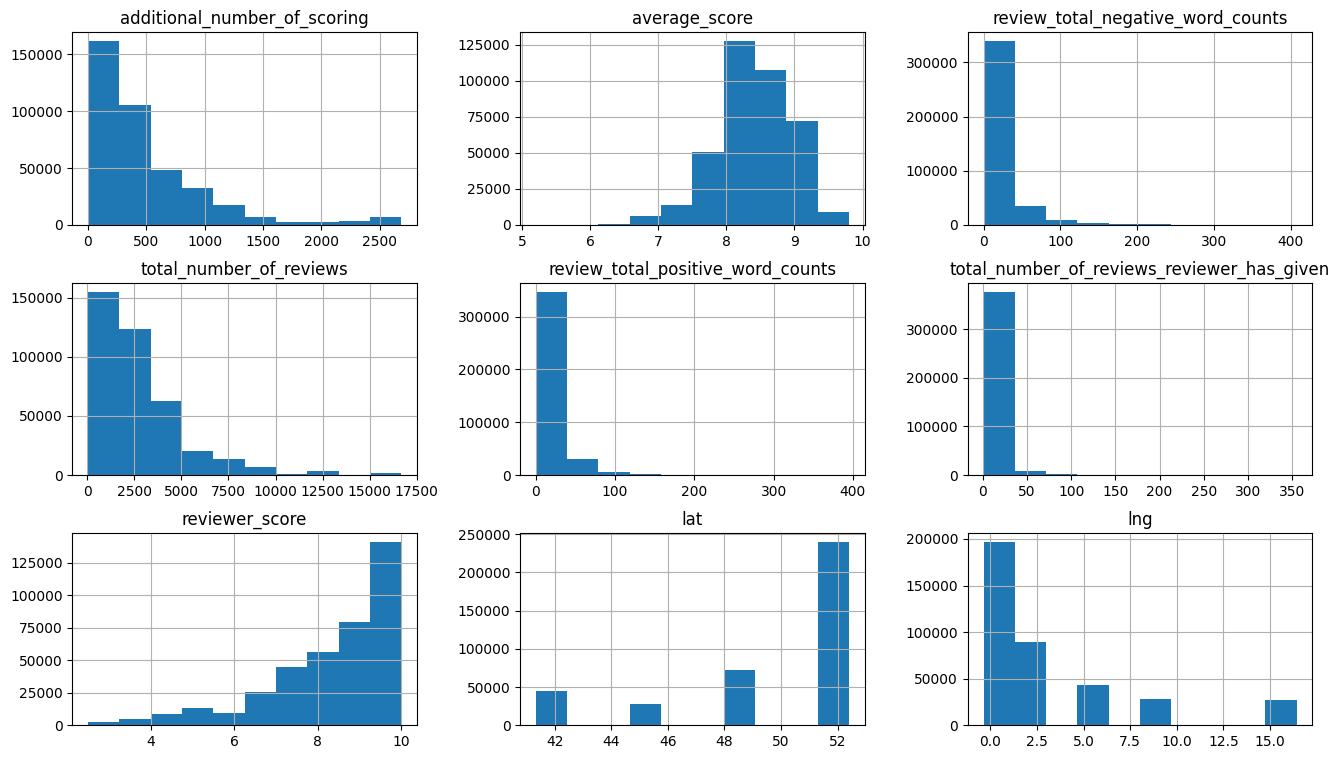

In [12]:
hotels[num_features].hist(figsize=(16,9));

Построим диаграммы рассеяния для признаков:

<Figure size 1600x1600 with 0 Axes>

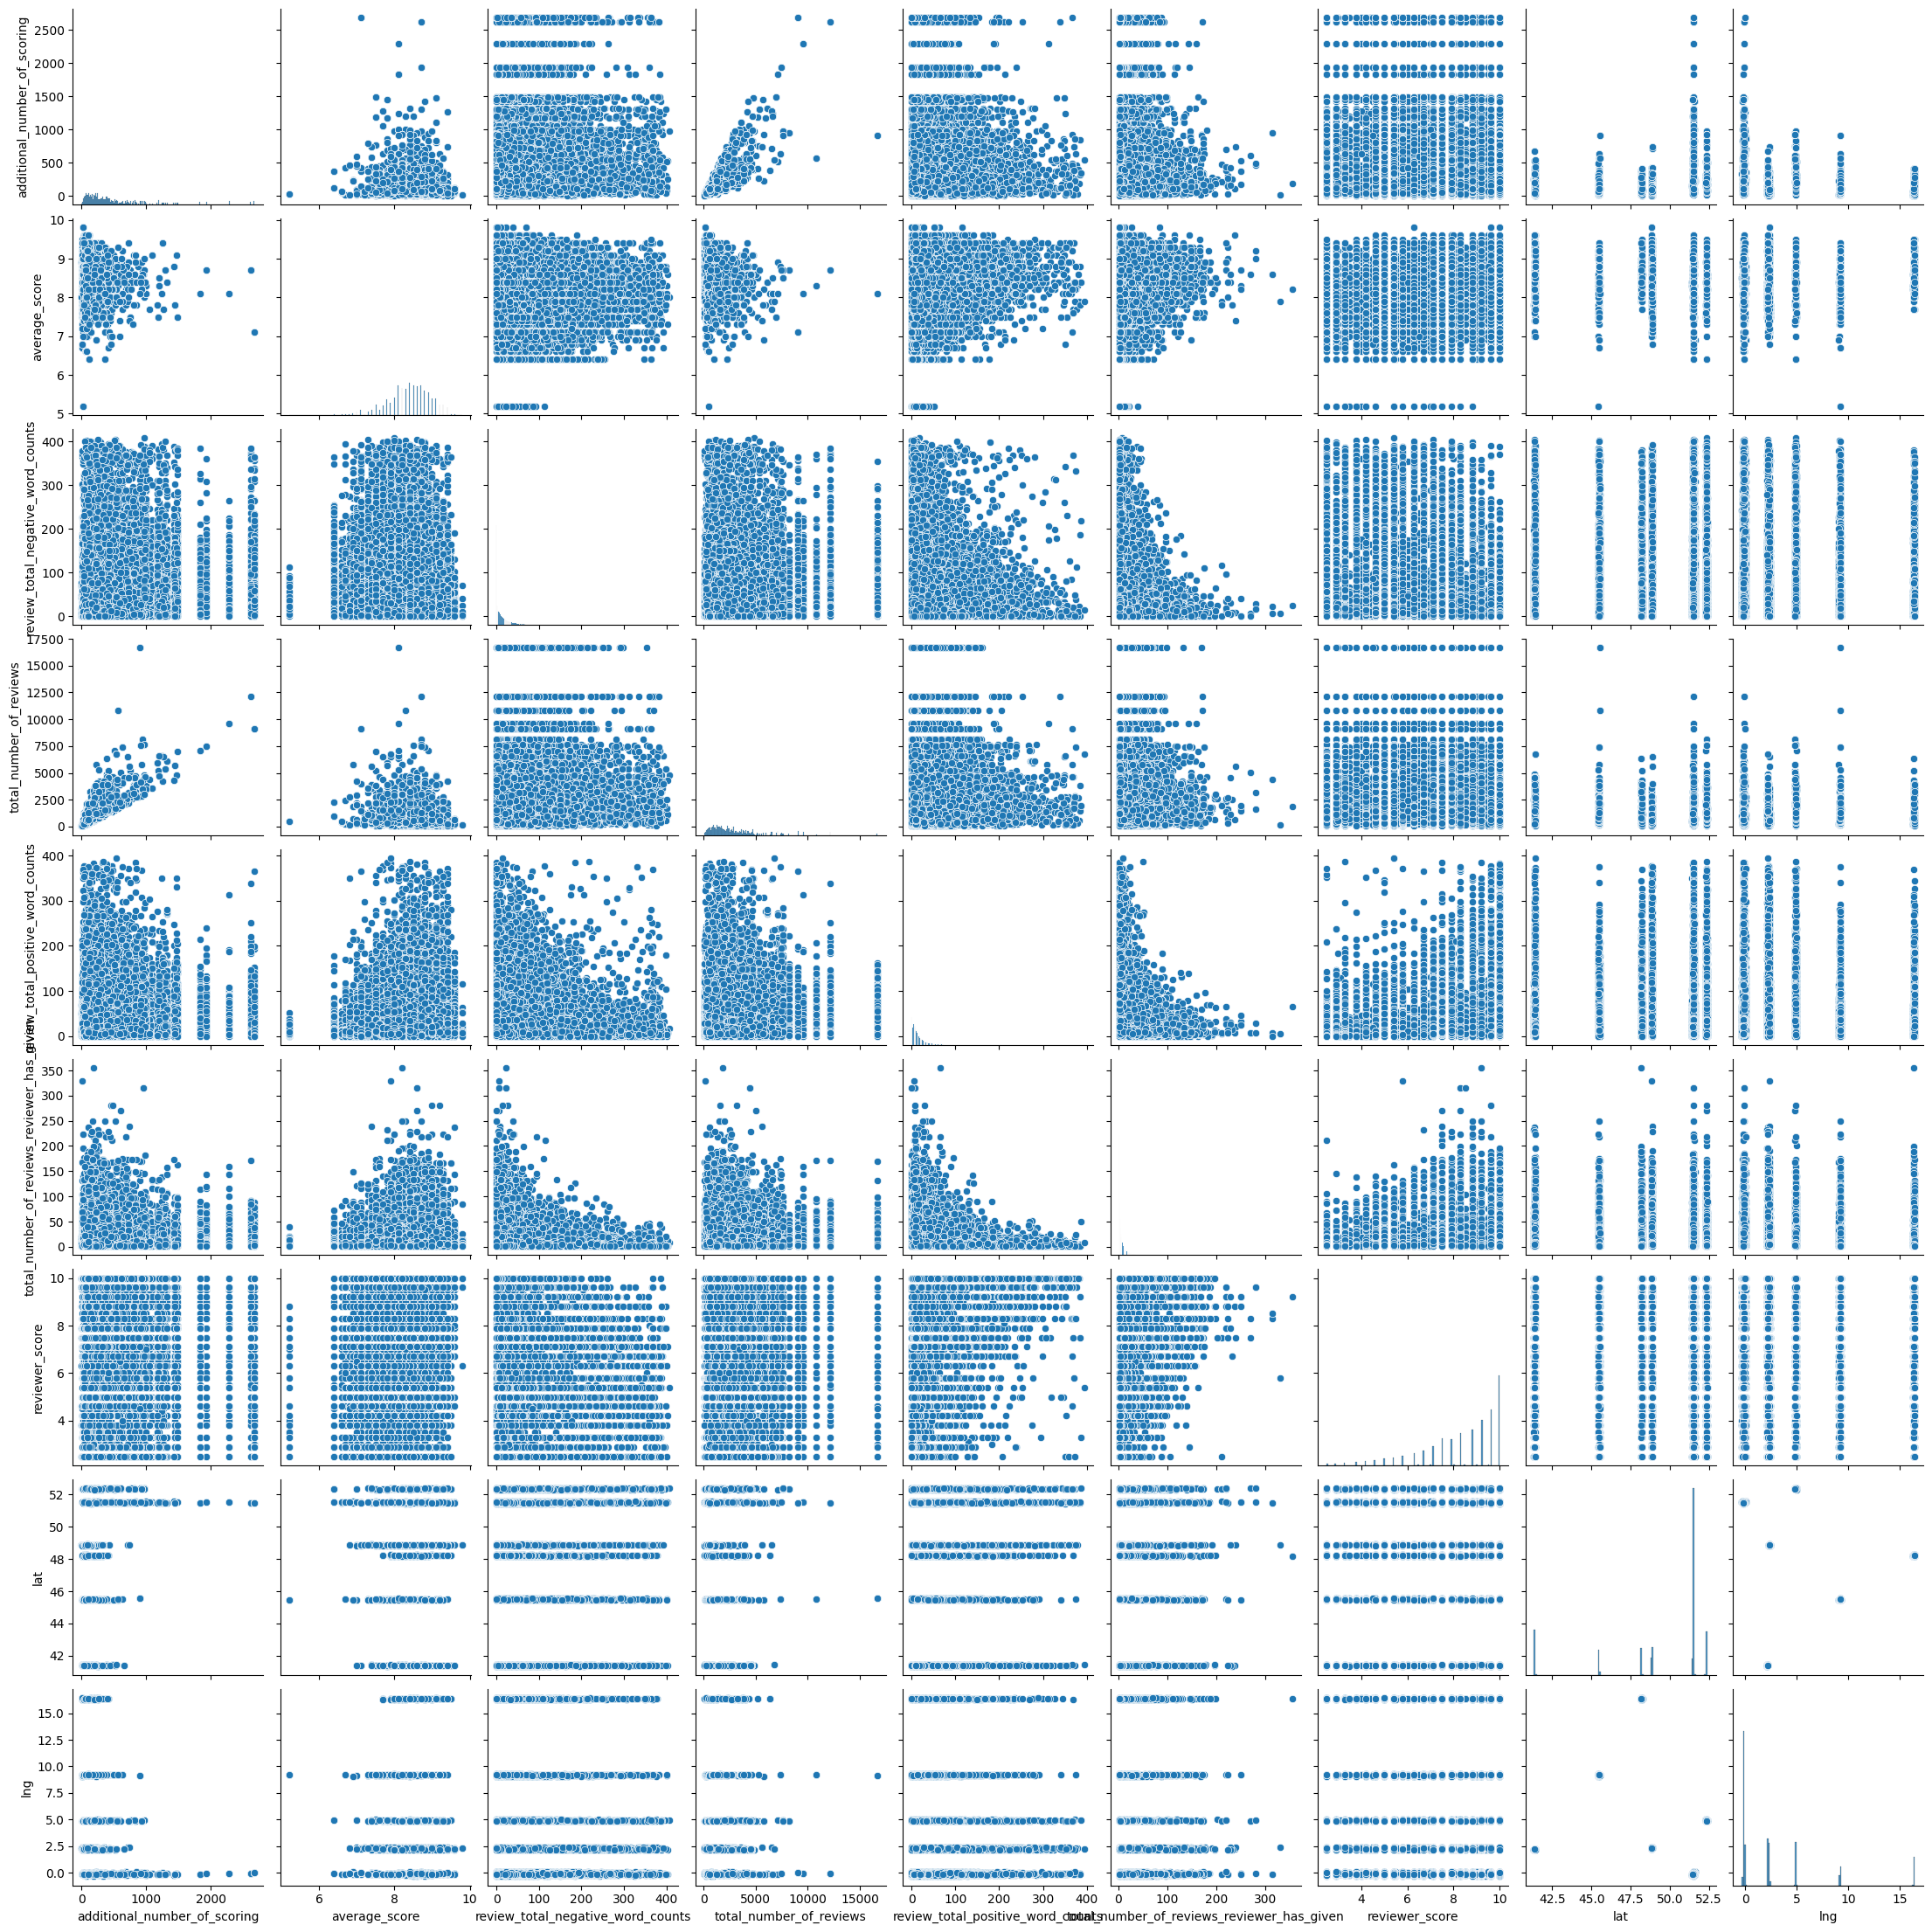

In [13]:
plt.figure(figsize=(16,16))
sns.pairplot(hotels[num_features]);

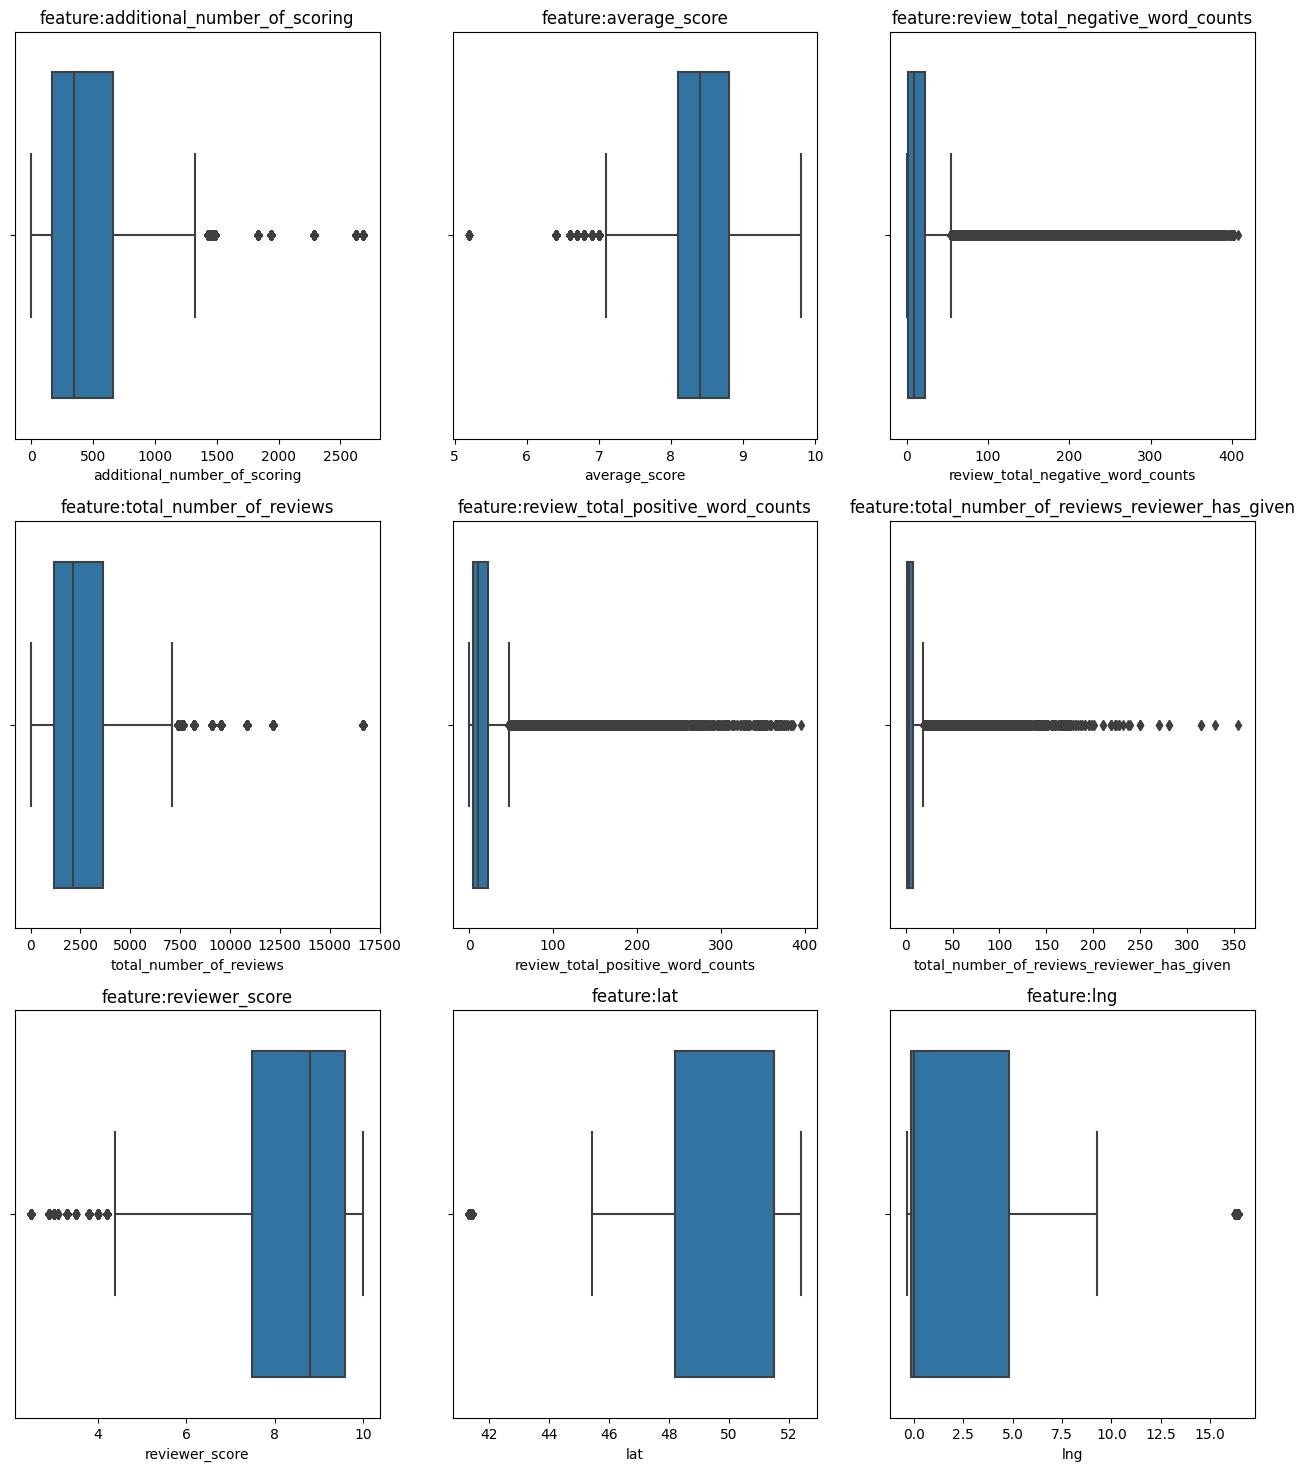

In [14]:
multi_hist(hotels, num_features, mode='box')

### ПРОПУСКИ

Поглядим на пропуски:

In [15]:
hotels.isna().mean().sort_values(ascending=False)

lng                                           0.006329
lat                                           0.006329
positive_review                               0.000000
days_since_review                             0.000000
tags                                          0.000000
reviewer_score                                0.000000
total_number_of_reviews_reviewer_has_given    0.000000
review_total_positive_word_counts             0.000000
hotel_address                                 0.000000
additional_number_of_scoring                  0.000000
review_total_negative_word_counts             0.000000
negative_review                               0.000000
reviewer_nationality                          0.000000
hotel_name                                    0.000000
average_score                                 0.000000
review_date                                   0.000000
total_number_of_reviews                       0.000000
dtype: float64

Пропуски есть только в столбцах **'lat'** и **'lng'** и их довольно мало. Попробуем с ними что-нибудь сделать.

Вместо того, чтобы заполнять координаты нулями, попробуем вытащить географические координаты из адреса. Не будем искать точных координат, это потребует работы с API для геосайтов и не требуется в задании, хотя и очень хочется :) Но увы, тем более, что например, API Google Maps платный.

Сделаем проще. Вытащим город из адреса (и заодно страну):

In [16]:
def get_city(data):
    lst = data.split()
    # у англичан хитрый адрес, сделаем условие
    if lst[-2] == 'United':
        return lst[-5]
    else:
        return lst[-2]
    
def get_country(data):
    lst = data.split()
    if lst[-2] == 'United':
        return lst[-2] + ' ' + lst[-1]
    else:
        return lst[-1]    

hotels['city'] = hotels['hotel_address'].apply(get_city)
hotels['country'] = hotels['hotel_address'].apply(get_country)

Возьмем, что если не указаны координаты, то не указаны и широта, и долгота, а не только одна из них. Найдём координаты этих городов:

In [17]:
city_dict = {'Vienna':[48.2, 16.4], 'Paris':[48.8, 2.3], 'Barcelona':[41.3, 2.1]}

for k in city_dict.keys():
    hotels['lat'].fillna(city_dict[k][0], inplace=True)
    hotels['lng'].fillna(city_dict[k][1], inplace=True)

Удалим столбец города, поскольку он по сути совпадает со столбцом страны (корреляция этих признаков равна 1):

In [18]:
hotels.drop('city', inplace=True, axis=1)

### ВЫБРОСЫ

Попробуем поискать выбросы в данных с помощью метода $3\sigma$:

In [19]:
# def outliers_z_score(data, feature, n_sigma=3, log_scale=False):
#     if log_scale:
#         x = np.log(data[feature]+1)
#     else:
#         x = data[feature]
#     mu = x.mean()
#     sigma = x.std()
#     lower_bound = mu - n_sigma * sigma
#     upper_bound = mu + n_sigma * sigma
#     outliers = data[(x < lower_bound) | (x > upper_bound)]
#     cleaned = data[(x > lower_bound) & (x < upper_bound)]
#     return outliers, cleaned

# out_dict = {}

# for col in num_features:
#     # outliers, cleaned = outliers_z_score(hotels, col, n_sigma=3)
#     outliers, hotels = outliers_z_score(hotels, col, n_sigma=3)
#     print(f'Признак:', col, ' | Число выбросов по методу z-отклонения:', outliers.shape[0], ' | Процент выбросов:', round(outliers.shape[0] * 100 / (hotels[col].shape[0] + 0.1), 3))
#     out_dict[col] = outliers.shape[0]

# hotels = hotels.reset_index(drop=True)

Удаление выбросов по методу $3\sigma$ (как впрочем и в случае с изолирующим лесом) приводит к ухудшению метрики на финальной тестовой выборке.

### ПРЕОБРАЗОВАНИЕ И СОЗДАНИЕ ПРИЗНАКОВ

Переведём столбец *'review_date'* в формат даты, вытащим оттуда год и месяц:

In [20]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_year'] = hotels['review_date'].dt.year

#я не думаю, что можно взять больше данных из этого признака - удалим его
hotels.drop(['review_date'], axis=1, inplace=True)

Обработаем столбец с тэгами. Сделаем отдельный столбец, который будет суммой тегов в отзыве на основе частоты использования:

In [21]:
hotels['tags'] = hotels['tags'].str.replace('\[\' ', '')
hotels['tags'] = hotels['tags'].str.replace(' \'\]', '')
hotels['tags'] = hotels['tags'].str.split(' \', \' ')

tags = []

for i in range(hotels.shape[0]):
    tags.extend(hotels['tags'].loc[i])

tags_s = pd.Series(tags)
tags_s = tags_s.value_counts(True).sort_values(ascending=False)

# посчитаем условную сумму тэгов. поскольку знаем упоминаемость кажого тега в датасете, можно получить условный "вес" набора тегов
def tag_sum(data):
    sum = 0
    for col in data:
        sum += tags_s[col]
    return sum

hotels['tags_sum'] = hotels['tags'].apply(tag_sum)

C:\Users\maxim\AppData\Local\Temp\ipykernel_26844\2273153817.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  hotels['tags'] = hotels['tags'].str.replace('\[\' ', '')
C:\Users\maxim\AppData\Local\Temp\ipykernel_26844\2273153817.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  hotels['tags'] = hotels['tags'].str.replace(' \'\]', '')


Далее поглядим какие тэги вообще есть. Выведем, например, топ-30:

In [22]:
tags_s.head(30)

Leisure trip                      0.177420
Submitted from a mobile device    0.130566
Couple                            0.107049
Stayed 1 night                    0.082247
Stayed 2 nights                   0.056725
Solo traveler                     0.045960
Stayed 3 nights                   0.040735
Business trip                     0.035071
Group                             0.027772
Family with young children        0.025932
Stayed 4 nights                   0.020225
Double Room                       0.014928
Standard Double Room              0.013664
Superior Double Room              0.013324
Family with older children        0.011203
Deluxe Double Room                0.010536
Double or Twin Room               0.009518
Stayed 5 nights                   0.008832
Standard Double or Twin Room      0.007390
Classic Double Room               0.007194
Superior Double or Twin Room      0.005792
2 rooms                           0.005254
Stayed 6 nights                   0.004186
Standard Tw

Из этих тэгов пожалуй могут быть интересны следующие группы:
- отзыв с мобильного устройства
- тип поездки - *Leisure trip* и *Business trip*
- количество туристов - *Couple, Solo traveler, Group, Family with young children, Family with older children*
- длительность проживания - *Stayed...*
- тип комнаты

Посмотрим на них:

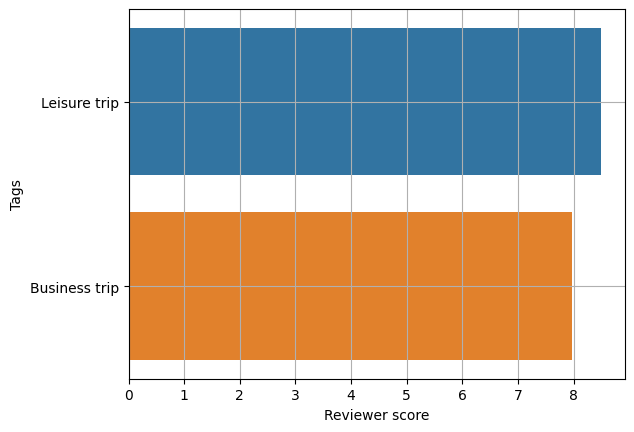

In [23]:
_ = tags_dependence(hotels, ['Leisure trip', 'Business trip'])

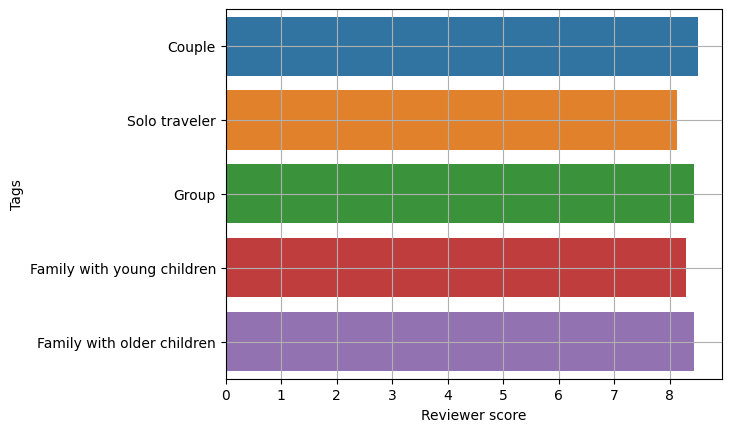

In [24]:
ttype_list = ['Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children']

_ = tags_dependence(hotels, ttype_list)

Можно сказать, что в этих двух группах есть зависимость оценки от типа поездки и количества туристов. Оставим их и закодируем:

In [25]:
hotels = pd.concat([hotels, tags_dependence(hotels, ttype_list, code=True)], axis=1)
hotels = pd.concat([hotels, tags_dependence(hotels, ['Leisure trip', 'Business trip'], code=True)], axis=1)

Посмотрим на следующую группу:

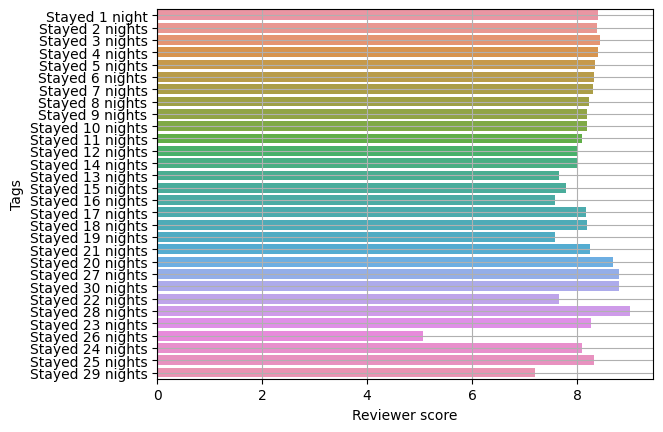

In [26]:
_ = tags_dependence(hotels, tags_group(tags_s, 'stayed'))

In [27]:
tags_s[tags_group(tags_s, 'stayed')]

Stayed 1 night      0.082247
Stayed 2 nights     0.056725
Stayed 3 nights     0.040735
Stayed 4 nights     0.020225
Stayed 5 nights     0.008832
Stayed 6 nights     0.004186
Stayed 7 nights     0.003139
Stayed 8 nights     0.001081
Stayed 9 nights     0.000547
Stayed 10 nights    0.000375
Stayed 11 nights    0.000173
Stayed 12 nights    0.000123
Stayed 14 nights    0.000104
Stayed 13 nights    0.000098
Stayed 15 nights    0.000049
Stayed 16 nights    0.000021
Stayed 17 nights    0.000015
Stayed 18 nights    0.000014
Stayed 19 nights    0.000013
Stayed 21 nights    0.000011
Stayed 20 nights    0.000010
Stayed 27 nights    0.000006
Stayed 30 nights    0.000006
Stayed 22 nights    0.000005
Stayed 28 nights    0.000004
Stayed 23 nights    0.000003
Stayed 26 nights    0.000003
Stayed 24 nights    0.000003
Stayed 25 nights    0.000002
Stayed 29 nights    0.000002
dtype: float64

Сократим количество - все длительности 5 дней и больше объединим в один тэг и закодируем:

In [28]:
duration_list = ['Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Stayed 4 nights', 'Stayed 5 nights']
temp = tags_dependence(hotels, tags_group(tags_s, 'stayed'), code=True)

for el in temp.columns:
    if el not in duration_list:
        temp['Stayed 5 nights'] = temp['Stayed 5 nights'] + temp[el]
        temp.drop(el, axis=1, inplace=True)

hotels = pd.concat([hotels, temp], axis=1)

Теперь разберёмся с комнатами. Поскольку различных тэгов для комнат очень много, попробуем это упростить:

Посмотрим топ-20 слов в описании комнат:

In [29]:
tags_df = pd.DataFrame(tags_s[tags_group(tags_s, 'room')]*100)
tags_df.reset_index(inplace=True)
tags_df.columns = ['room', 'percent']

tags_df.room = tags_df.room.str.replace('Room','')
tags_df.room = tags_df.room.str.replace('room','')

tags_df = pd.Series(tags_df.room.sum().split())
tags_df.value_counts(True).sort_values(ascending=False).head(20)

with         0.118195
Double       0.098185
Twin         0.054909
or           0.036606
Bed          0.024508
King         0.020785
Deluxe       0.019544
2            0.019544
1            0.019234
Queen        0.018613
Superior     0.015976
and          0.015511
Single       0.013650
Executive    0.013340
Sofa         0.009772
3            0.008376
Two          0.008066
Spa          0.008066
Lounge       0.008066
City         0.007135
dtype: float64

Видим, что разделить комнаты на типы довольно сложно. Оставим пока как есть.

Теперь у нас осталось разобраться с тэгом *Submitted from a mobile device*:

In [30]:
temp = tags_dependence(hotels, tags_group(tags_s, 'submitted'), code=True)

hotels = pd.concat([hotels, temp], axis=1)
s1 = hotels.loc[hotels['Submitted from a mobile device'] == 1, 'reviewer_score'].mean()
s2 = hotels.loc[hotels['Submitted from a mobile device'] == 0, 'reviewer_score'].mean()

print(f'Средняя оценка с активным тэгом: {round(s1, 2)}, средняя оценка без тэга: {round(s2, 2)}')

Средняя оценка с активным тэгом: 8.42, средняя оценка без тэга: 8.37


Разница совсем небольшая, но оставим этот признак.

Удалим признак *tags*, поскольку мы уже вытащили из него всё, что можно (ну или почти :)

In [31]:
hotels = hotels.drop('tags', axis=1)

Преобразуем признак **'days_since_review'** в числовой:

In [32]:
hotels['days_since_review'] = hotels['days_since_review'].str.split()
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x[0]))

Разберёмя с национальностью рецензента. Имеем 225 различных национальностей. Посмотрим на процентное соотношение:

In [33]:
hotels['reviewer_nationality'].value_counts(True).sort_values(ascending=False).head(20)*100

 United Kingdom               47.577966
 United States of America      6.861632
 Australia                     4.198261
 Ireland                       2.876400
 United Arab Emirates          1.969219
 Saudi Arabia                  1.737836
 Netherlands                   1.708363
 Switzerland                   1.679925
 Canada                        1.547041
 Germany                       1.539802
 France                        1.433029
 Israel                        1.271448
 Italy                         1.179412
 Belgium                       1.170880
 Turkey                        1.061264
 Kuwait                        0.957076
 Spain                         0.912351
 Romania                       0.885464
 Russia                        0.763438
 South Africa                  0.746633
Name: reviewer_nationality, dtype: float64

Попробуем перевести страны в континенты:

In [34]:
#если названия страны нет, то страна будет Великобритания, поскольку эта страна является модой
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: 'United Kingdom' if len(x) < 3 else x)

hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.lstrip()
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.rstrip()

hotels['reviewer_continent'] = hotels['reviewer_nationality'].apply(country_to_continent)

In [35]:
#удалим reviewer_nationality за ненадобностью
hotels = hotels.drop('reviewer_nationality', axis=1)

Посмотрим на средние оценки в разрезе континента:

<AxesSubplot: xlabel='reviewer_continent', ylabel='reviewer_score'>

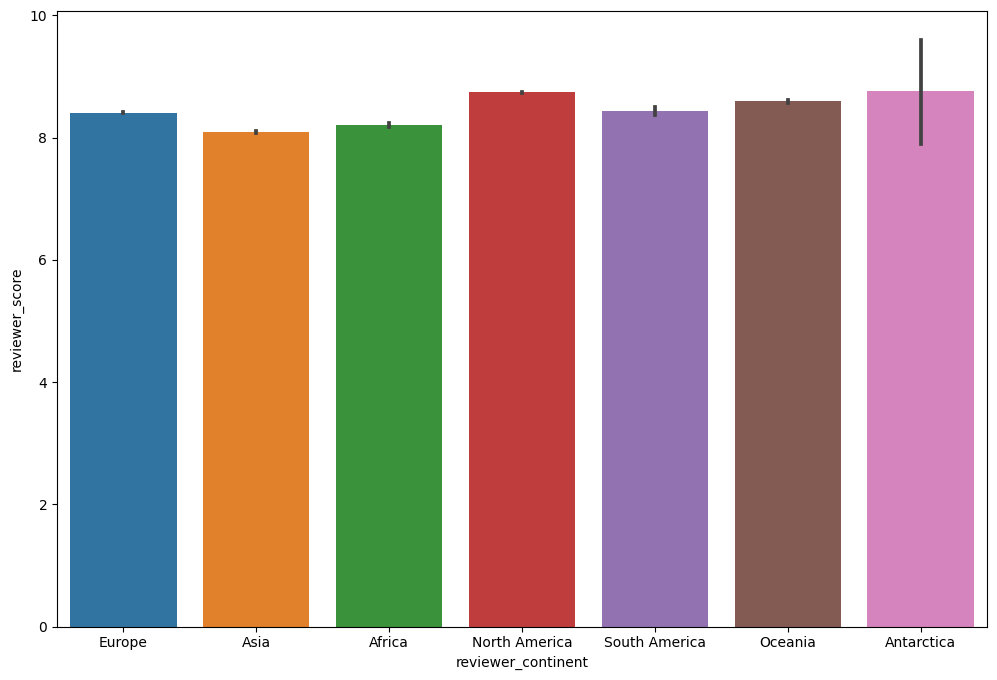

In [36]:
plt.figure(figsize=(12,8))
sns.barplot(hotels, x=hotels['reviewer_continent'], y=hotels['reviewer_score'])

Теперь разберёмся с именами отелей. Попробуем вытащить из них сетевые. Список сетей ниже уже отредактирован, поэтому не такой большой:

In [37]:
hotels_chains_list = [
    'Ramada',
    'Marriott',
    'Hilton',
    'Doubletree',
    'InterContinental',
    'Holiday Inn',
    'Crowne Plaza',
    'Staybridge Suite',
    'Sofitel',
    'Novotel',
    'Pullman',
    'Mercure',
    'Suite Hotel',
    'Ibis',
    'Comfort Inn',
    'Hyatt',
    'Best Western',
    'Radisson',
    'Sheraton',
    'Westin',
    'Le Meridien',
    'Aloft'
]

hotels['hotel_chain'] = 0

for el in hotels_chains_list:
    filter = hotels['hotel_name'].str.find(el) != -1
    num = hotels.loc[filter, 'hotel_name'].count()
    uniq = hotels.loc[filter, 'hotel_address'].value_counts().shape[0]
    hotels.loc[filter, 'hotel_chain'] = 1
    print(f'Сеть {el}: {num} отелей в датасете, {uniq} уникальных.')

Сеть Ramada: 1543 отелей в датасете, 2 уникальных.
Сеть Marriott: 4754 отелей в датасете, 25 уникальных.
Сеть Hilton: 26710 отелей в датасете, 43 уникальных.
Сеть Doubletree: 1505 отелей в датасете, 2 уникальных.
Сеть InterContinental: 397 отелей в датасете, 5 уникальных.
Сеть Holiday Inn: 11925 отелей в датасете, 25 уникальных.
Сеть Crowne Plaza: 3675 отелей в датасете, 10 уникальных.
Сеть Staybridge Suite: 526 отелей в датасете, 2 уникальных.
Сеть Sofitel: 2444 отелей в датасете, 14 уникальных.
Сеть Novotel: 7365 отелей в датасете, 26 уникальных.
Сеть Pullman: 2158 отелей в датасете, 5 уникальных.
Сеть Mercure: 7842 отелей в датасете, 50 уникальных.
Сеть Suite Hotel: 414 отелей в датасете, 2 уникальных.
Сеть Ibis: 16 отелей в датасете, 2 уникальных.
Сеть Comfort Inn: 334 отелей в датасете, 1 уникальных.
Сеть Hyatt: 1451 отелей в датасете, 8 уникальных.
Сеть Best Western: 11325 отелей в датасете, 53 уникальных.
Сеть Radisson: 8423 отелей в датасете, 15 уникальных.
Сеть Sheraton: 261 о

Удалим уже ненужные столбцы:

In [38]:
hotels = hotels.drop(['hotel_address', 'hotel_name'], axis=1)

Осталось разобраться с положительными и отрицательными отзывами. Посмотрим на них:

In [39]:
#обрежем пробелы

hotels['negative_review'] = hotels['negative_review'].str.lstrip()
hotels['negative_review'] = hotels['negative_review'].str.rstrip()

hotels['positive_review'] = hotels['positive_review'].str.lstrip()
hotels['positive_review'] = hotels['positive_review'].str.rstrip()

In [40]:
hotels['positive_review'].value_counts().head(30)

No Positive                   26885
Location                       7496
Everything                     2146
location                       1296
Nothing                        1101
Great location                 1089
The location                    982
Good location                   904
Breakfast                       493
Friendly staff                  453
Excellent location              410
Staff                           370
Location and staff              283
everything                      272
Location was great              217
Location was good               216
Everything was perfect          210
Comfy bed                       192
Good breakfast                  176
The staff                       176
nothing                         176
Location is great               173
good location                   167
Perfect location                166
Location location location      165
Location staff                  160
Location is good                155
Breakfast was good          

In [41]:
hotels['negative_review'].value_counts().head(30)

No Negative                  95907
Nothing                      13891
nothing                       1879
None                           871
N A                            818
                               606
Nothing really                 435
N a                            391
All good                       367
Small room                     340
No complaints                  330
Breakfast                      326
Location                       323
Nothing at all                 293
Everything                     287
Nothing to dislike             255
none                           236
Price                          226
Nil                            212
Everything was perfect         185
n a                            181
Small rooms                    180
Can t think of anything        171
Absolutely nothing             164
Leaving                        164
Everything was great           161
Nothing to complain about      139
Expensive                      135
Nothing not to like 

Как можно увидеть, нам нужно поработать с отзывами, поскольку часть негативных отзывов совсем не негативные, и наоборот:

In [42]:
# негативные отзывы
negatives_ = [
    'No Negative',
    'Nothing',
    'nothing',
    'N A',
    'None',
    'N a',
    'Nothing at all',
    'Nothing to dislike',
    'Absolutely nothing',
    'Can t think of anything',
    'No complaints',
    'Nothing to complain about',
    'Nothing not to like',
    'NA',
    'Na',
    'Nothing in particular',
    'Non',
    'Not applicable'
]
for neg in negatives_:
    hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace(neg, 'nothing'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('Everything', 'terrible'))

#позитивные отзывы
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.replace('No positive', 'nothing'))

С помощью библиотеки *Afinn* преобразуем отзывы в числовой формат:

In [43]:
afinn = Afinn()

hotels['negative_afinn'] = hotels['negative_review'].apply(lambda x: afinn.score(x))
hotels['positive_afinn'] = hotels['positive_review'].apply(lambda x: afinn.score(x))

После преобразования в рейтинг, удалим столбцы отзывов:

In [44]:
hotels = hotels.drop(['negative_review', 'positive_review'], axis=1)

### КОДИРОВАНИЕ ПРИЗНАКОВ + БОРЬБА С МУЛЬТИКОЛЛИЕАРНОСТЬЮ

Разобьём признаки на числовые и категориальные:

In [45]:
types = hotels.dtypes
num_features = list(types[(types != 'object')].index)
cat_features = list(types[(types == 'object')].index)
print(len(cat_features), cat_features)
print(len(num_features), num_features)

2 ['country', 'reviewer_continent']
29 ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'days_since_review', 'lat', 'lng', 'review_month', 'review_year', 'tags_sum', 'Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Leisure trip', 'Business trip', 'Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Stayed 4 nights', 'Stayed 5 nights', 'Submitted from a mobile device', 'hotel_chain', 'negative_afinn', 'positive_afinn']


Закодируем категориальные столбцы:

In [46]:
encoder_or = ce.OneHotEncoder(cols=cat_features)
hotels_coded = encoder_or.fit_transform(hotels[cat_features])
hotels = hotels.drop(cat_features, axis=1)
hotels = pd.concat([hotels, hotels_coded], axis=1)

In [47]:
# кодирование для финальной тестовой выборки
# hotels_coded = encoder_or.transform(hotels[cat_features])
# hotels = hotels.drop(cat_features, axis=1)
# hotels = pd.concat([hotels, hotels_coded], axis=1)

Посмотрим на матрицу корреляции. Выведем коррелирующие столбцы:

In [48]:
corr_matr = hotels.corr()

thresh = 0.8
cols_to_drop_corr = []

for i, ind in enumerate(corr_matr.index):
    cols = list(corr_matr.columns)[i:]
    cols.remove(ind)
    for col in cols:
        if abs(corr_matr.loc[ind, col]) > thresh:
            cols_to_drop_corr.append([col, ind])

cols_to_drop_corr

[['total_number_of_reviews', 'additional_number_of_scoring'],
 ['review_year', 'days_since_review'],
 ['country_6', 'lat'],
 ['country_5', 'lng'],
 ['Business trip', 'Leisure trip']]

Посмотрим, как эти признаки коррелируют с целевой переменной:

In [49]:
features_to_drop = list(set([elem for cols in cols_to_drop_corr for elem in cols]))
corr_dict = {}
for f in features_to_drop:
    corr_dict[f] = round(corr_matr.loc['reviewer_score', f], 4)

corr_dict

{'total_number_of_reviews': -0.0734,
 'country_5': 0.0272,
 'lng': 0.033,
 'additional_number_of_scoring': -0.0618,
 'Business trip': -0.1134,
 'lat': -0.0368,
 'country_6': 0.0348,
 'days_since_review': 0.0024,
 'Leisure trip': 0.118,
 'review_year': 0.011}

Удалим коррелирующие столбцы с наименьшей связью с целевым признаком:

In [50]:
cols = ['days_since_review', 'Business trip', 'country_5', 'country_6', 'additional_number_of_scoring']
hotels.drop(columns=cols, axis=1, inplace=True)

Выведем тепловую карту для матрицы корреляции:

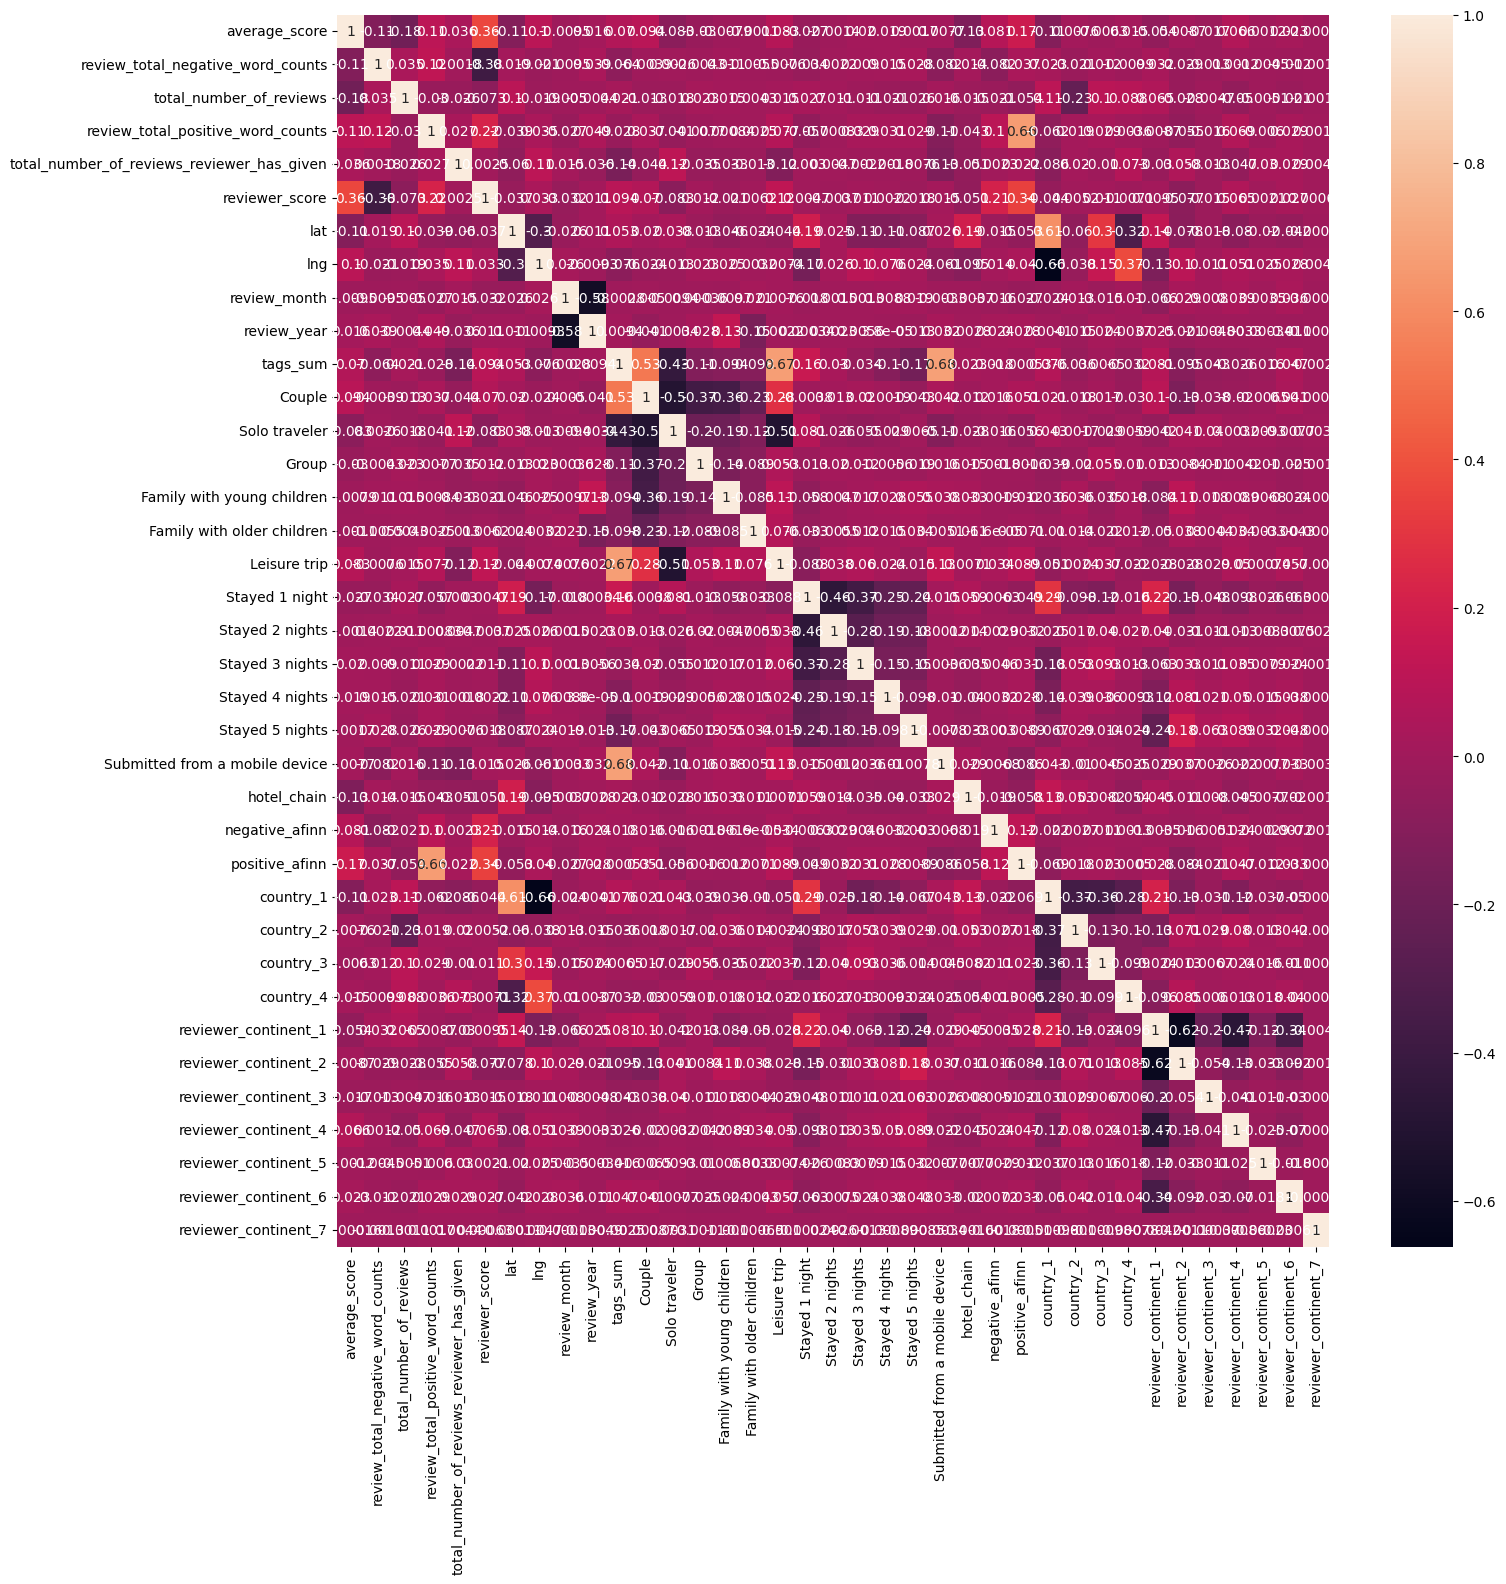

In [51]:
plt.figure(figsize = (16, 16))
sns.heatmap(hotels.corr(), annot=True);

### ПОДГОТОВКА И РАСЧЁТ МОДЕЛИ

Разделим датасет на признаки и целевую переменную:

In [52]:
hotels_m = hotels.copy()

X = hotels_m.drop('reviewer_score', axis=1)  
y = hotels_m['reviewer_score']

Поищем оптимальное количество признаков. Ищет *RFECV* достаточно долго (около 3.5 часов), поэтому просто выведем полученные результаты:

In [53]:
# model_ = CatBoostRegressor(
#     eval_metric='MAPE',
#     iterations=2000,
#     random_seed=100,
#     learning_rate=0.1,
#     depth=8,
#     early_stopping_rounds=50
# )

# rfecv_ = RFECV(estimator=model_)

# pipeline_ = Pipeline([('Feature Selection', rfecv_), ('Model', model_)])
# pipeline_.fit(X, y)

# print('Оптимальное количество признаков: ', rfecv_.n_features_)

# n_scores = len(rfecv_.cv_results_["mean_test_score"])
# plt.figure(figsize=(14,8))
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test metrics")
# plt.errorbar(
#     range(rfecv_.min_features_to_select, n_scores + rfecv_.min_features_to_select),
#     rfecv_.cv_results_["mean_test_score"],
#     yerr=rfecv_.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show();

# Оптимальное количество признаков:  32

In [54]:
# получим оптимальное количество признаков и их имена
# features_ = rfecv_.feature_names_in_[rfecv_.support_]

features_ = [
    'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
    'lat', 'lng', 'review_month', 'review_year', 'tags_sum', 'Couple', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Leisure trip',
    'Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights', 'Stayed 4 nights', 'Stayed 5 nights', 'Submitted from a mobile device', 'hotel_chain', 'negative_afinn',
    'positive_afinn', 'country_2', 'country_4', 'reviewer_continent_1', 'reviewer_continent_2', 'reviewer_continent_3', 'reviewer_continent_4', 'reviewer_continent_6'
]

X = X[features_]

Разделим выборку на тестовую и обучающую:

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

#### CatBoost

In [56]:
from catboost import CatBoostRegressor

model_CAT=CatBoostRegressor(
    eval_metric='MAPE',
    iterations=5000,
    random_seed=100,
    learning_rate=0.025,
    depth=8,
    early_stopping_rounds=50
)
model_CAT.fit(
    X_train, y_train,
    #cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Посмотрим на зависимости:

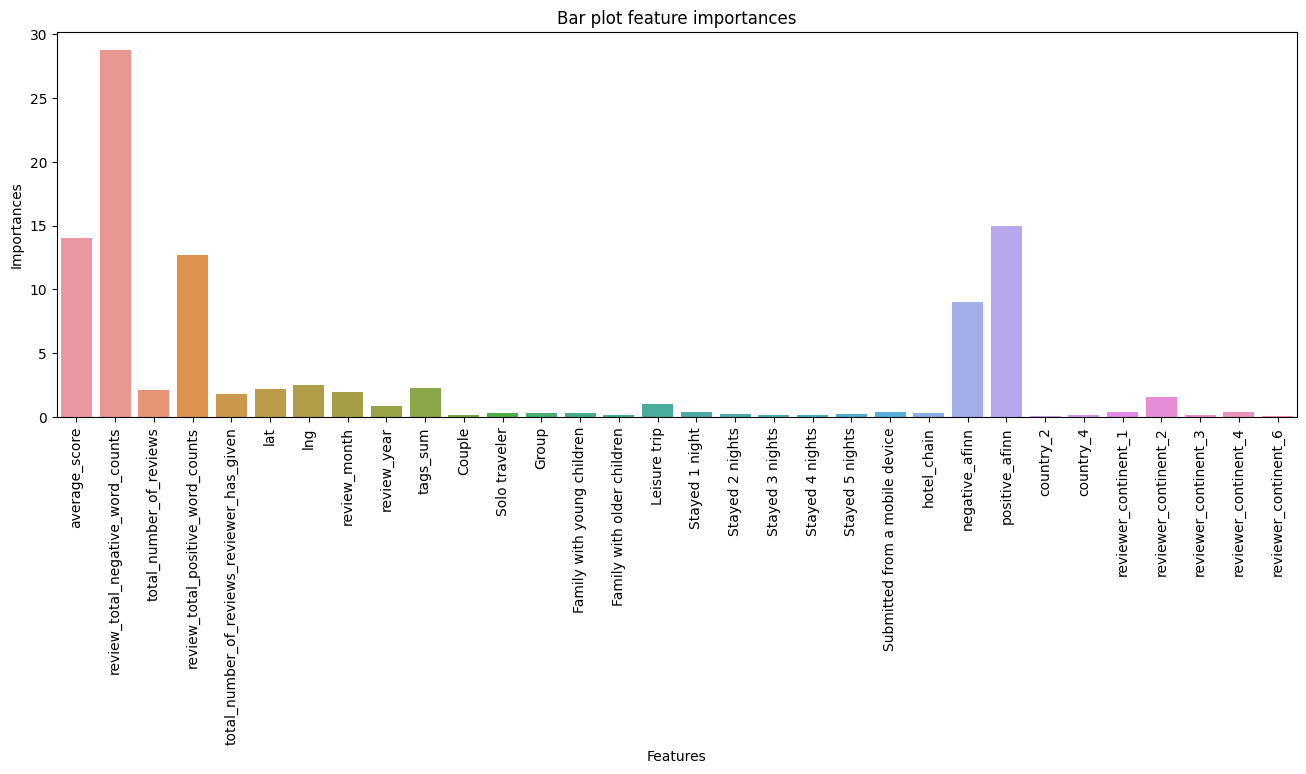

In [57]:
fig, ax = plt.subplots(figsize=(16, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = model_CAT.feature_importances_ #важность признаков

sns.barplot(x=feature, y=feature_importances, ax=ax);

ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Importances');

In [58]:
# записываем ответы в файл
# submission = pd.read_csv('data/submission.csv')

# hotels.drop('reviewer_score', axis=1, inplace=True)
# test_pred = model_CAT.predict(hotels)

# submission['reviewer_score'] = test_pred[:]
# submission.to_csv('data/submission.csv', index = False)